# Explore Data In Redshift

In [1]:
# Install SQL Alchemy
!pip install -q SQLAlchemy==1.3.13

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-scheduler 2.7.1 requires sqlalchemy<3,>=2.0, but you have sqlalchemy 1.3.13 which is incompatible.
langchain 0.1.9 requires SQLAlchemy<3,>=1.4, but you have sqlalchemy 1.3.13 which is incompatible.
langchain-community 0.0.38 requires SQLAlchemy<3,>=1.4, but you have sqlalchemy 1.3.13 which is incompatible.


### Set Redshift Connection Parameters

In [2]:
redshift_schema = "redshift"
redshift_cluster_identifier = "dsoaws"
redshift_host = "dsoaws"
redshift_database = "dsoaws"
redshift_port = "5439"
redshift_table_2015 = "amazon_reviews_tsv_2015"
redshift_table_2014 = "amazon_reviews_tsv_2014"

### Load the Redshift Secrets from Secrets Manager

In [3]:
import json
import boto3

secretsmanager = boto3.client("secretsmanager")

secret = secretsmanager.get_secret_value(SecretId="dsoaws_redshift_login")
cred = json.loads(secret["SecretString"])

redshift_username = cred[0]["username"]
redshift_pw = cred[1]["password"]

In [4]:
redshift = boto3.client("redshift")

response = redshift.describe_clusters(ClusterIdentifier=redshift_cluster_identifier)

redshift_endpoint_address = response["Clusters"][0]["Endpoint"]["Address"]

print(redshift_endpoint_address)

dsoaws.cvwk8weidfxy.us-east-1.redshift.amazonaws.com


## Create the Redshift Connection

In [6]:
!pip install awswrangler

  Using cached awswrangler-3.9.0-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.9.0-py3-none-any.whl (381 kB)


In [7]:
import awswrangler as wr

con_redshift = wr.data_api.redshift.connect(
    cluster_id=redshift_cluster_identifier,
    database=redshift_database,
    db_user=redshift_username,
)

### Using APPROXIMATE COUNT for 'blazing fast' results

The COUNT function counts the rows defined by the expression.

The COUNT function has three variations. COUNT ( * ) counts all the rows in the target table whether they include nulls or not. COUNT ( expression ) computes the number of rows with non-NULL values in a specific column or expression. COUNT ( DISTINCT expression ) computes the number of distinct non-NULL values in a column or expression.

When used with APPROXIMATE, a COUNT ( DISTINCT expression ) function uses a HyperLogLog algorithm to approximate the number of distinct non-NULL values in a column or expression. Queries that use the APPROXIMATE keyword execute much faster, with a low relative error of around 2%. Approximation is warranted for queries that return a large number of distinct values, in the millions or more per query, or per group, if there is a group by clause. For smaller sets of distinct values, in the thousands, approximation might be slower than a precise count. APPROXIMATE can only be used with COUNT ( DISTINCT ).

#### Compare the query execution times of the two queries below.

In [8]:
%%time
df = wr.data_api.redshift.read_sql_query(
    sql="""SELECT approximate count(distinct customer_id)
                        FROM {}.{}
                        GROUP BY product_category""".format(
        redshift_schema, redshift_table_2015
    ),
    con=con_redshift,
)

CPU times: user 42.4 ms, sys: 39.9 ms, total: 82.3 ms
Wall time: 13.4 s


In [9]:
%%time
df = wr.data_api.redshift.read_sql_query(
    sql="""SELECT count(distinct customer_id)
                                FROM {}.{}
                                GROUP BY product_category""".format(
            redshift_schema, redshift_table_2015
    ),
    con=con_redshift,
)

CPU times: user 27.9 ms, sys: 3.53 ms, total: 31.4 ms
Wall time: 8.77 s


### Let's do some Visualizations

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
statement = """
SELECT product_category,
COUNT(star_rating) AS count_star_rating
FROM {}.{}
GROUP BY product_category
ORDER BY count_star_rating DESC
""".format(
    redshift_schema, redshift_table_2015
)

print(statement)


SELECT product_category,
COUNT(star_rating) AS count_star_rating
FROM redshift.amazon_reviews_tsv_2015
GROUP BY product_category
ORDER BY count_star_rating DESC



In [12]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)

In [13]:
df.head()

,product_category,count_star_rating
0,Gift Card,44000
1,Digital_Software,35585
2,Digital_Video_Games,30026


In [14]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

3


In [15]:
# Store max ratings
max_ratings = df["count_star_rating"].max()
print(max_ratings)

44000


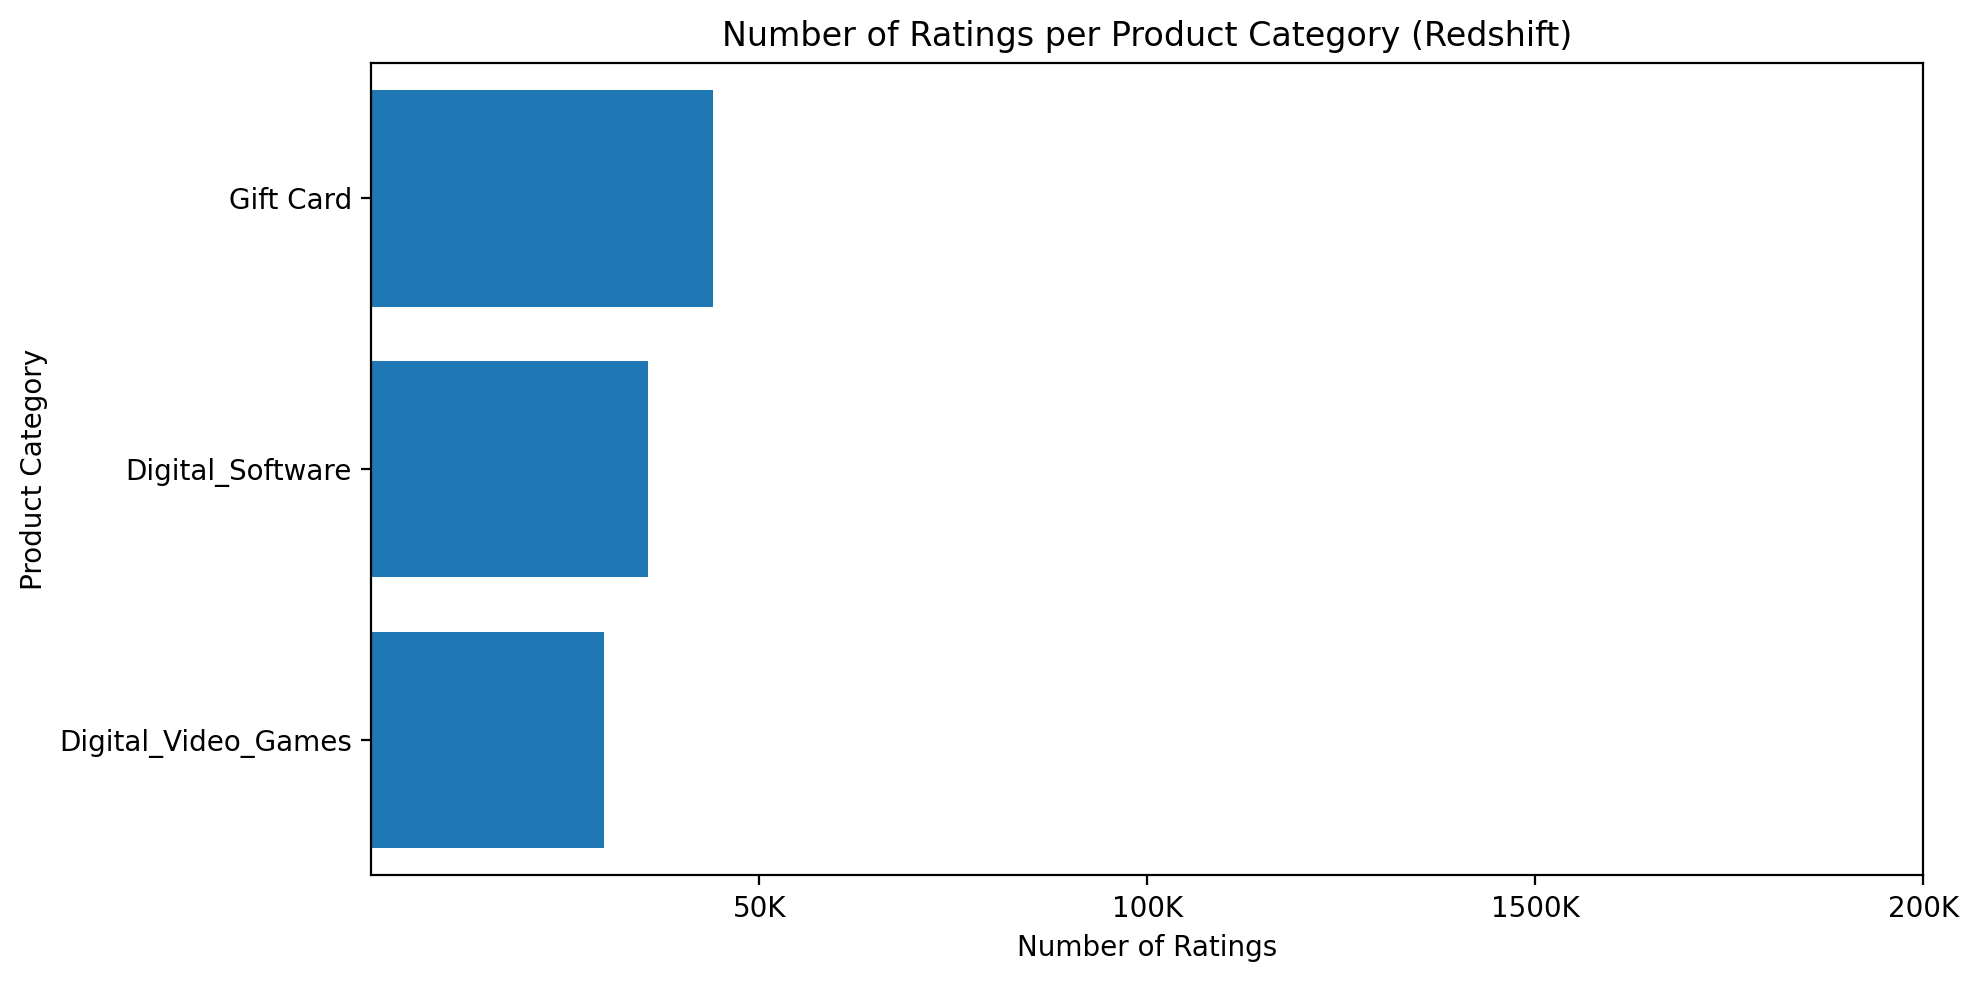

In [17]:
# Set size and style to use
if num_categories > 10:
    plt.figure(figsize=(10, 10))
else:
    plt.figure(figsize=(10, 5))

# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category (Redshift)")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
if max_ratings <= 8000:
    plt.xticks(
        [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000],
        ["10K", "20K", "30K", "40K", "50K", "60K", "70K", "80K"],
    )
    plt.xlim(0, 80000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "1500K", "200K"])
    plt.xlim(0, 200000)
elif max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Query Athena using Redshift Spectrum

In [18]:
athena_schema = "athena"
athena_table_name = "amazon_reviews_tsv"

In [19]:
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating
FROM {}.{}
GROUP BY product_category
ORDER BY count_star_rating DESC
""".format(
    athena_schema, athena_table_name
)

print(statement)


SELECT product_category, COUNT(star_rating) AS count_star_rating
FROM athena.amazon_reviews_tsv
GROUP BY product_category
ORDER BY count_star_rating DESC



In [20]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)
df.head(5)

,product_category,count_star_rating
0,Gift Card,149086
1,Digital_Video_Games,145431
2,Digital_Software,102084


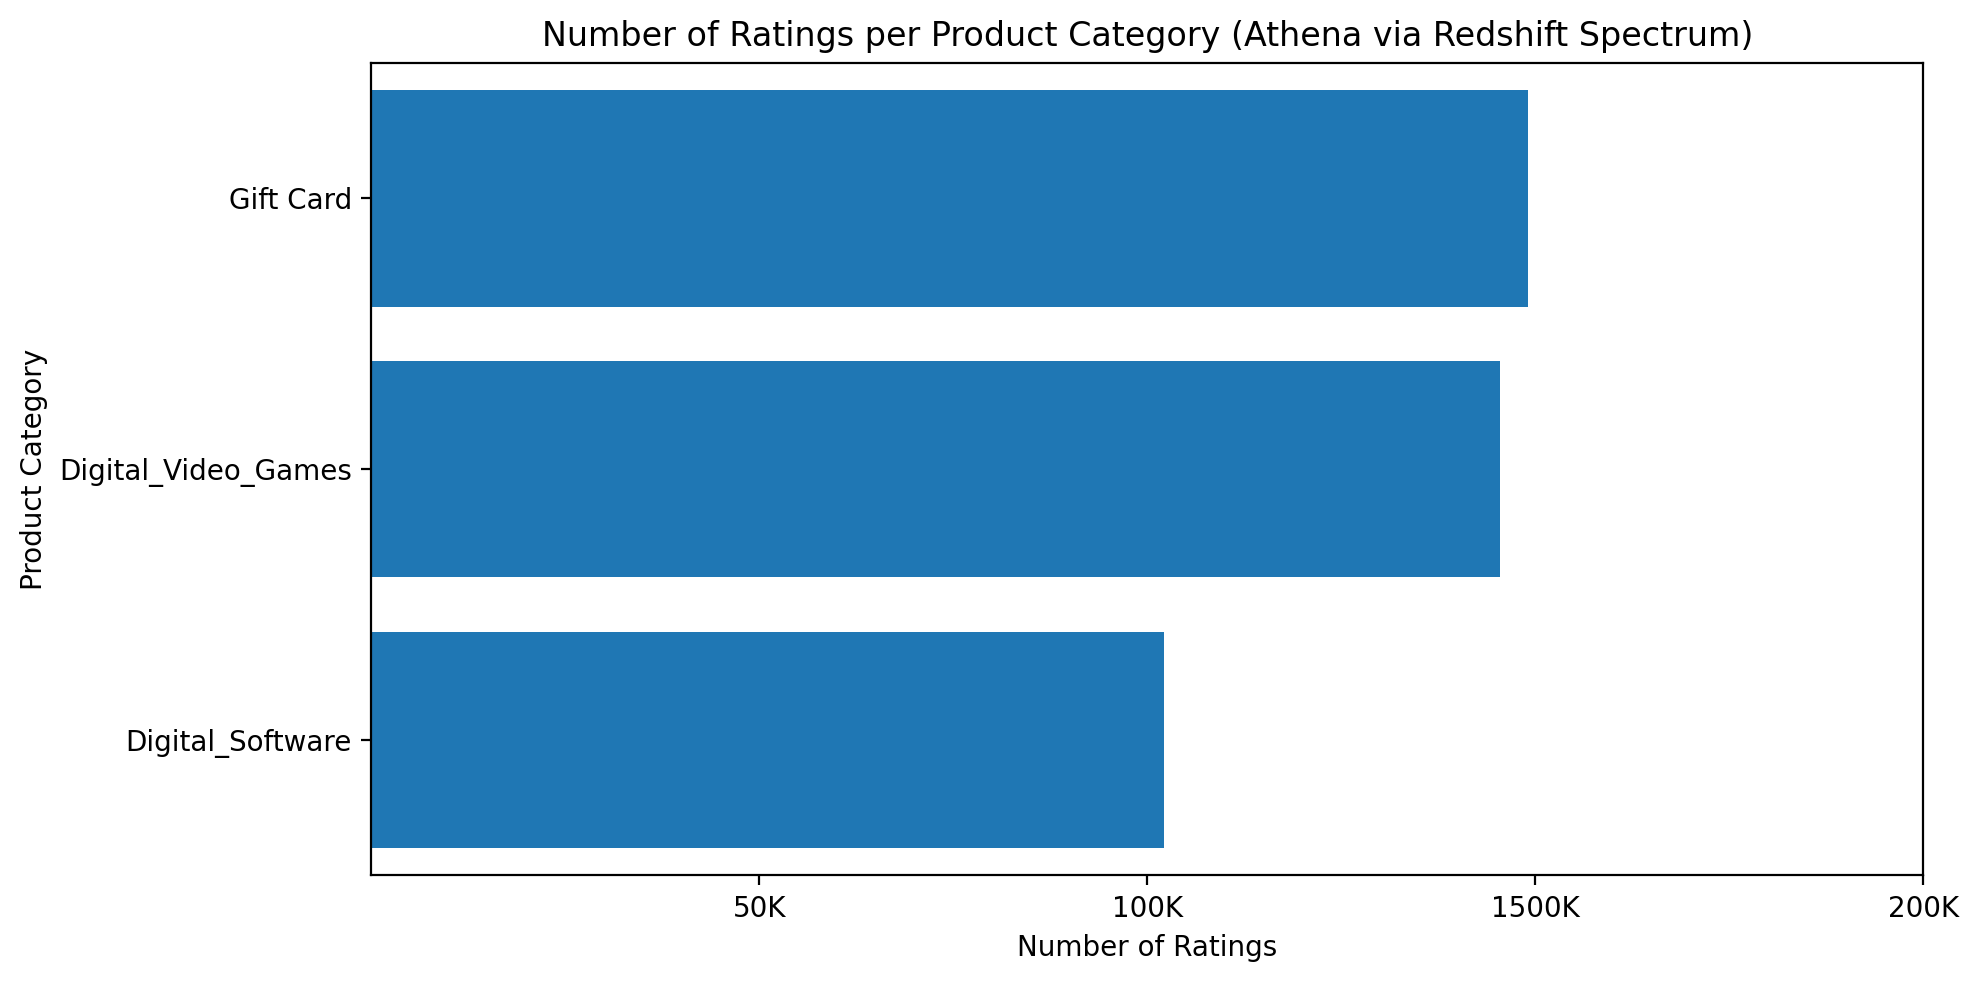

In [22]:
# Set size and style to use
if num_categories > 10:
    plt.figure(figsize=(10, 10))
else:
    plt.figure(figsize=(10, 5))

# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category (Athena via Redshift Spectrum)")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
if max_ratings <= 8000:
    plt.xticks(
        [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000],
        ["10K", "20K", "30K", "40K", "50K", "60K", "70K", "80K"],
    )
    plt.xlim(0, 80000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "1500K", "200K"])
    plt.xlim(0, 200000)
elif max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

In [ ]:
# Release Resources

In [2]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

In [3]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>

<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}
</script>